In [1]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pertpy as pt
import scanpy as sc
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Run Mixscape in pertpy

In [2]:
mdata = pt.dt.papalexi_2021()
sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=2000, flavor='seurat_v3', subset=True)
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])

mdata["rna"].layers["scaled"] = mdata["rna"].X.copy()
sc.pp.scale(mdata["rna"], layer="scaled")
sc.pp.pca(mdata["rna"], n_comps=50, layer="scaled")

In [3]:
# If you want to ensure that the PCA embeddings are the exact same as those computed by Seurat, load them from a CSV file
#mdata["rna"].obsm["X_pca"] = np.genfromtxt("/Users/mamba/Desktop/PCA_embeddings.csv", delimiter=",", skip_header=1, usecols=range(1, 50))

mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.perturbation_signature(
    mdata["rna"], "perturbation", "NT", split_by="replicate", n_neighbors=20, n_dims=40,
)

In [4]:
# The perturbation signature computed by Seurat's Mixscape implementation were stored in a CSV file
orig_pert_signature = pd.read_csv("/Users/mamba/Desktop/PRTB_results.csv", index_col=0)
orig_pert_signature = orig_pert_signature.T.loc[mdata["rna"].obs_names, mdata["rna"].var_names]

Text(0.5, 1.0, 'Correlation: 0.97, p-value: 0.0000')

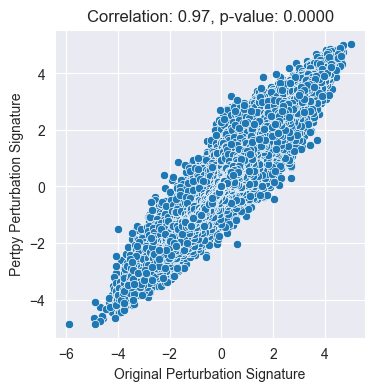

In [5]:
#Correlation between original and pertpy perturbation signature
plt.figure(figsize=(4, 4))
sns.scatterplot(x=orig_pert_signature.values.flatten(), y=mdata["rna"].layers["X_pert"].A.flatten())
plt.xlabel("Original Perturbation Signature")
plt.ylabel("Pertpy Perturbation Signature")

corr_coeff, p_val = pearsonr(orig_pert_signature.values.flatten(), mdata["rna"].layers["X_pert"].A.flatten())
plt.title(f"Correlation: {corr_coeff:.2f}, p-value: {p_val:.4f}")

In [30]:
mixscape_identifier.mixscape(
    adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert", split_by="replicate", random_state=42
)

In [31]:
mixscape_identifier.lda(
    adata=mdata["rna"], control="NT", labels="gene_target", split_by="replicate"
)

# Load Mixscape results

In [32]:
adata_pertpy = mdata["rna"]
adata_pertpy

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'mixscape', 'mixscape_lda'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled', 'X_pert'

In [17]:
# Load Mixscape results from Seurat's Mixscape implementation
adata_original = ad.read_h5ad('output/mixscape_original.h5ad')
adata_original

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global'
    var: 'features'
    obsm: 'X_prtbpca', 'X_prtbumap', 'X_umap'
    varm: 'PRTBPCA'

# Mixscape class comparison

In [33]:
np.all(adata_pertpy.obs_names == adata_original.obs_names)

True

In [34]:
np.all(sorted(adata_pertpy.var_names) == sorted(adata_original.var_names))

True

In [35]:
class_pertpy = adata_pertpy.obs["mixscape_class_global"]
class_original = adata_original.obs["mixscape_class.global"]

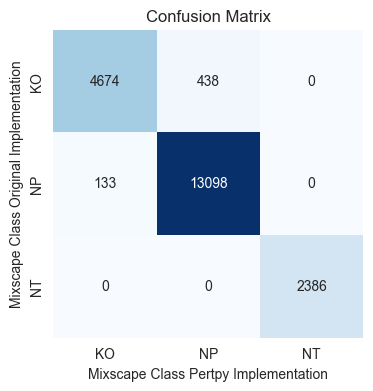

In [36]:
cm = confusion_matrix(class_original, class_pertpy)
unique_classes = sorted(class_original.unique())
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Mixscape Class Pertpy Implementation")
plt.ylabel("Mixscape Class Original Implementation")
plt.title("Confusion Matrix")
plt.show()